# <center>Предсказание цены продажи подержаного автомобиля</center>
## Знакомство с данными

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import optuna

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

pio.renderers.default = 'png'
plt.style.use('dark_background')

In [2]:
RANDOM_STATE = 42
N_JOBS = -1
def print_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print('Train R2-score:', metrics.r2_score(y_train, y_train_pred))
    print('Test R2-score:', metrics.r2_score(y_test, y_test_pred))
    print('---'*5)
    print('Train MAE:', metrics.mean_absolute_error(y_train, y_train_pred))
    print('Test MAE:', metrics.mean_absolute_error(y_test, y_test_pred))
    print('---'*5)
    print('Train MAPE:', metrics.mean_absolute_percentage_error(y_train, y_train_pred)*100)
    print('Test MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100)

In [3]:
original_data = pd.read_csv('data/CAR DETAILS FROM CAR DEKHO.csv')
data = original_data.copy()
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [5]:
data.describe(include='object').T

,count,unique,top,freq
name,4340,1491,Maruti Swift Dzire VDI,69
fuel,4340,5,Diesel,2153
seller_type,4340,3,Individual,3244
transmission,4340,2,Manual,3892
owner,4340,5,First Owner,2832


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,4340.0,2013.090783,4.215344,1992.0,2011.00,2014.0,2016.0,2020.0
selling_price,4340.0,504127.311751,578548.736139,20000.0,208749.75,350000.0,600000.0,8900000.0
km_driven,4340.0,66215.777419,46644.102194,1.0,35000.00,60000.0,90000.0,806599.0


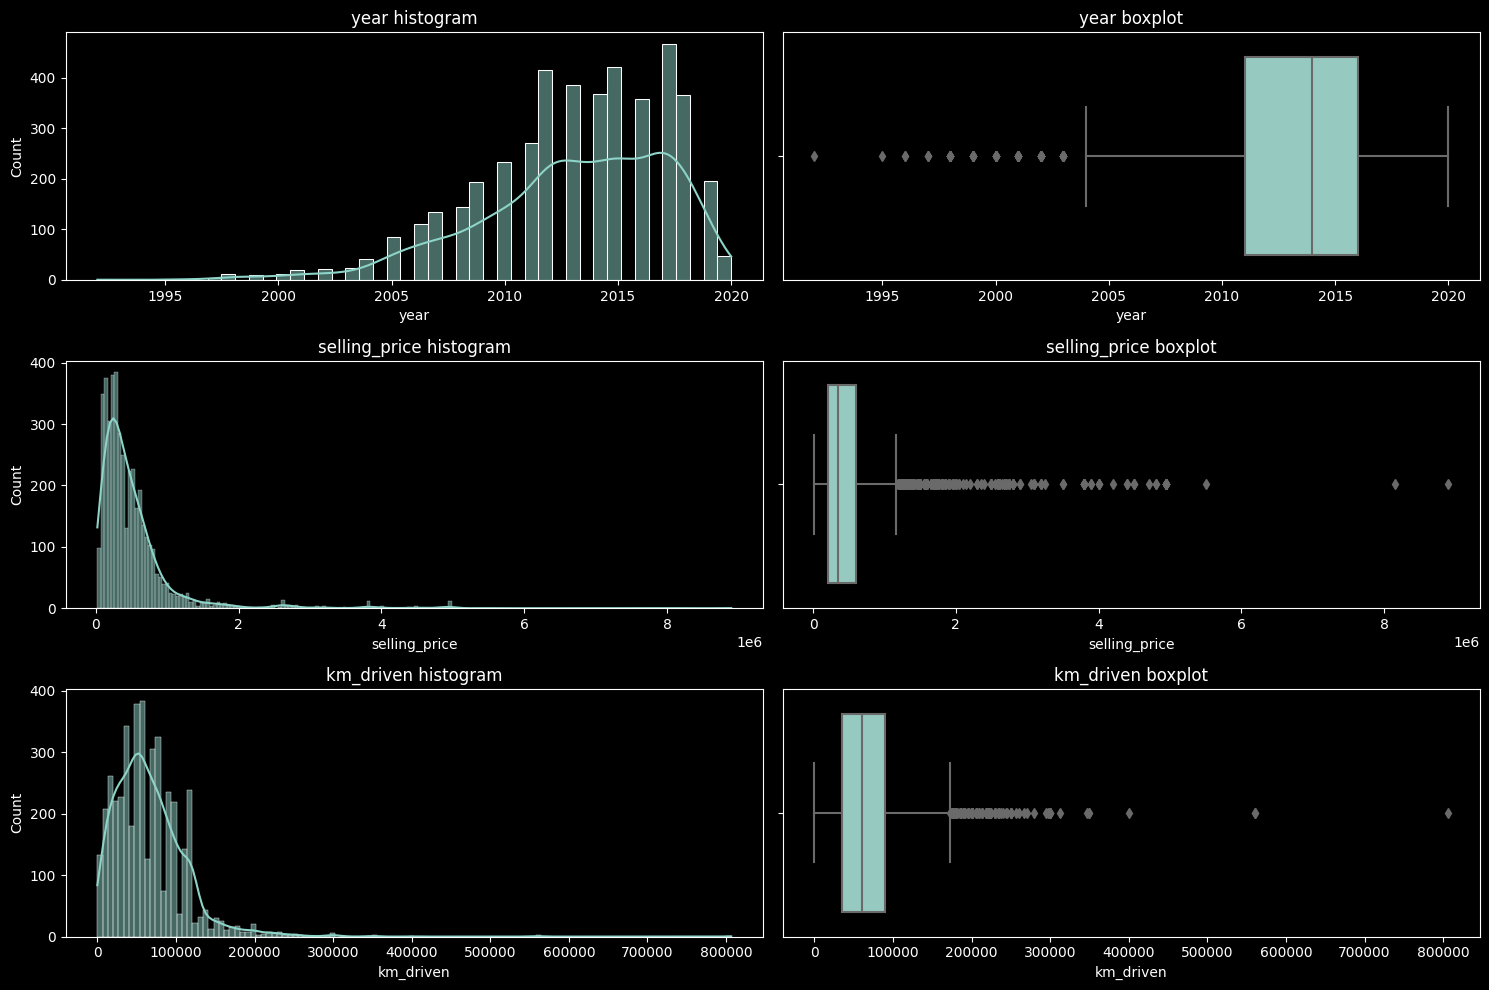

In [7]:
def make_histbox(data, features:list):
    fig, axs = plt.subplots(len(features), 2, figsize=(15, 10))
    for feature, row in zip(features, range(len(features))):
        ax, ay = axs[row, 0], axs[row, 1]
        sns.histplot(data, x=feature, ax=ax, kde=True)
        sns.boxplot(data, x=feature, ax=ay)
        ax.set_title(feature + ' histogram')
        ay.set_title(feature + ' boxplot')
    fig.tight_layout()
num_cols = [col for col in data.columns if data[col].dtype != 'object']
make_histbox(data, num_cols)

## Очистка и предобработка данных

In [8]:
data = data[data['selling_price'] < 4e6]
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,4314.0,2013.063978,4.210173,1992.0,2011.00,2014.0,2016.0,2020.0
selling_price,4314.0,477077.545897,455474.306211,20000.0,200249.75,350000.0,600000.0,3899000.0
km_driven,4314.0,66375.313630,46681.138376,1.0,35000.00,60000.0,90000.0,806599.0


In [9]:
data['name'].sample(20)

1844                   Toyota Fortuner 4x2 AT
4103             Tata Manza Aura Safire BS IV
2592                 Chevrolet Beat Diesel LT
4098                          Honda Brio S MT
2813     Audi Q3 2.0 TDI Quattro Premium Plus
2612                  Mahindra XUV500 W10 2WD
2444                            Maruti 800 EX
4022                 Maruti Wagon R LXI Minor
2467                      Mahindra Scorpio EX
4294                Mahindra XUV500 AT W8 FWD
1968                     Ford Figo Petrol ZXI
363      Ford Figo Diesel Celebration Edition
3799                Toyota Innova 2.5 G1 BSIV
4149    Toyota Innova 2.5 G (Diesel) 7 Seater
949                         Tata Nano Lx BSIV
2020                      Mahindra Bolero SLX
3206                         OpelCorsa 1.4 GL
4261              Tata Sumo GX TC 7 Str BSIII
511                  Skoda Laura L n K 1.9 PD
2245               Hyundai Grand i10 Magna AT
Name: name, dtype: object

In [10]:
data['car_manufacturer'] = data['name'].apply(lambda name: name.split()[0])
data.drop(columns='name', inplace=True)
data.sample(10)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,car_manufacturer
2180,2015,750000,45974,Diesel,Trustmark Dealer,Manual,First Owner,Maruti
226,2012,180000,120000,Diesel,Individual,Manual,First Owner,Chevrolet
349,2017,550000,38000,Petrol,Dealer,Manual,First Owner,Maruti
832,2011,120000,20000,Petrol,Individual,Manual,First Owner,Tata
3951,2011,225000,30000,Petrol,Individual,Manual,First Owner,Hyundai
3282,2015,270000,59258,Petrol,Dealer,Manual,First Owner,Maruti
749,2017,700000,60000,Diesel,Individual,Manual,First Owner,Renault
1883,2017,800000,26000,Diesel,Individual,Manual,Second Owner,Mahindra
3090,2013,310000,59100,CNG,Dealer,Manual,First Owner,Maruti
2684,2012,300000,80000,Diesel,Individual,Manual,First Owner,Maruti


In [11]:
data['car_manufacturer'].describe()

count       4314
unique        29
top       Maruti
freq        1280
Name: car_manufacturer, dtype: object

## Визуализация зависимостей в данных

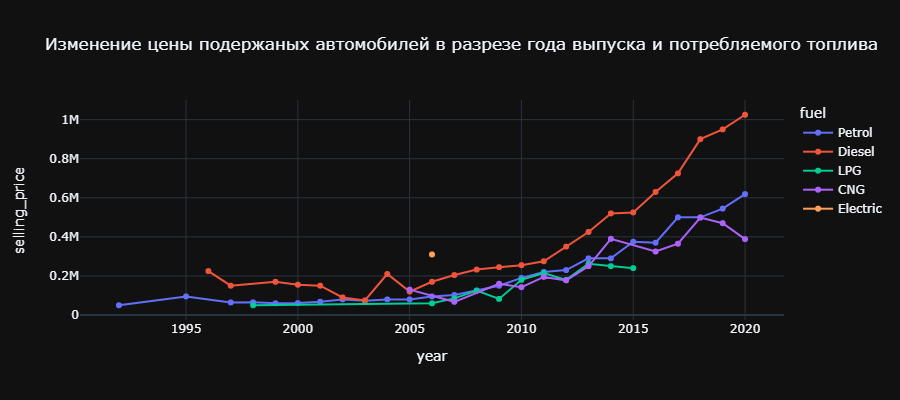

In [12]:
grouped_by_year = data.groupby(['year', 'fuel'], as_index=False)[['selling_price']].median()
px.line(
    grouped_by_year,
    x='year',
    y='selling_price',
    color='fuel',
    width=900,
    height=400,
    markers=True,
    title='Изменение цены подержаных автомобилей в разрезе года выпуска и потребляемого топлива',
    template='plotly_dark'
).show()

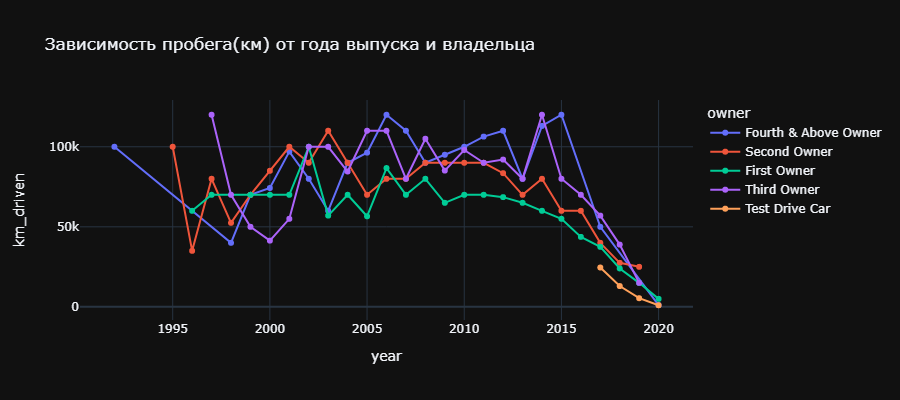

In [13]:
grouped_by_owner = data.groupby(['year', 'owner'], as_index=False)['km_driven'].median()
px.line(
    grouped_by_owner,
    x='year',
    y='km_driven',
    color='owner',
    width=900,
    height=400,
    markers=True,
    title='Зависимость пробега(км) от года выпуска и владельца',
    template='plotly_dark'
).show()

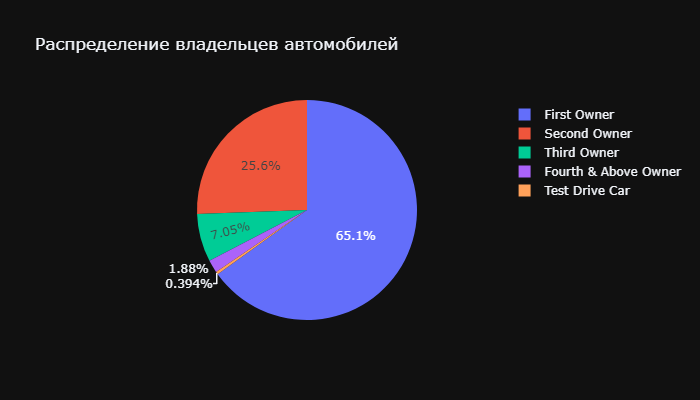

In [14]:
px.pie(
    data,
    names='owner',
    width=700,
    height=400,
    title='Распределение владельцев автомобилей',
    template='plotly_dark'
)

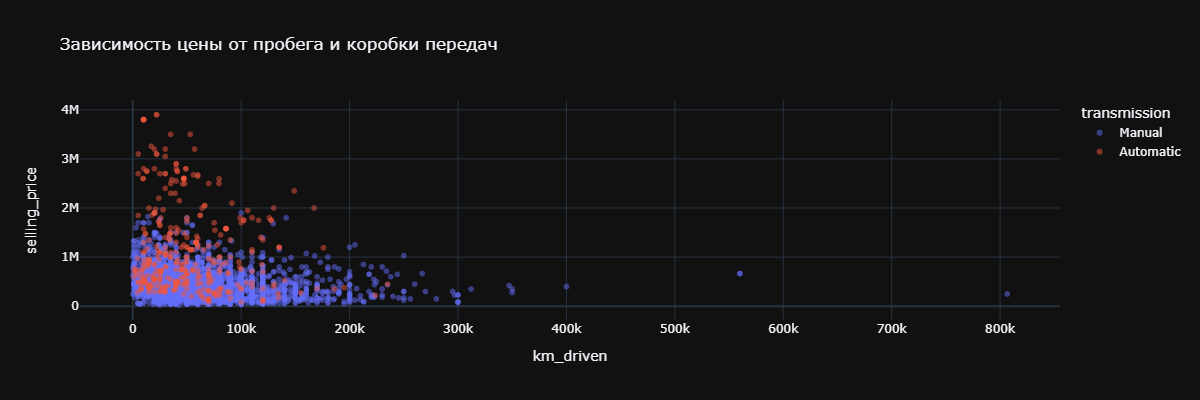

In [15]:
px.scatter(
    data,
    x='km_driven',
    y='selling_price',
    opacity=0.5,
    color='transmission',
    title='Зависимость цены от пробега и коробки передач',
    height=400,
    width=1200,
    template='plotly_dark'
)

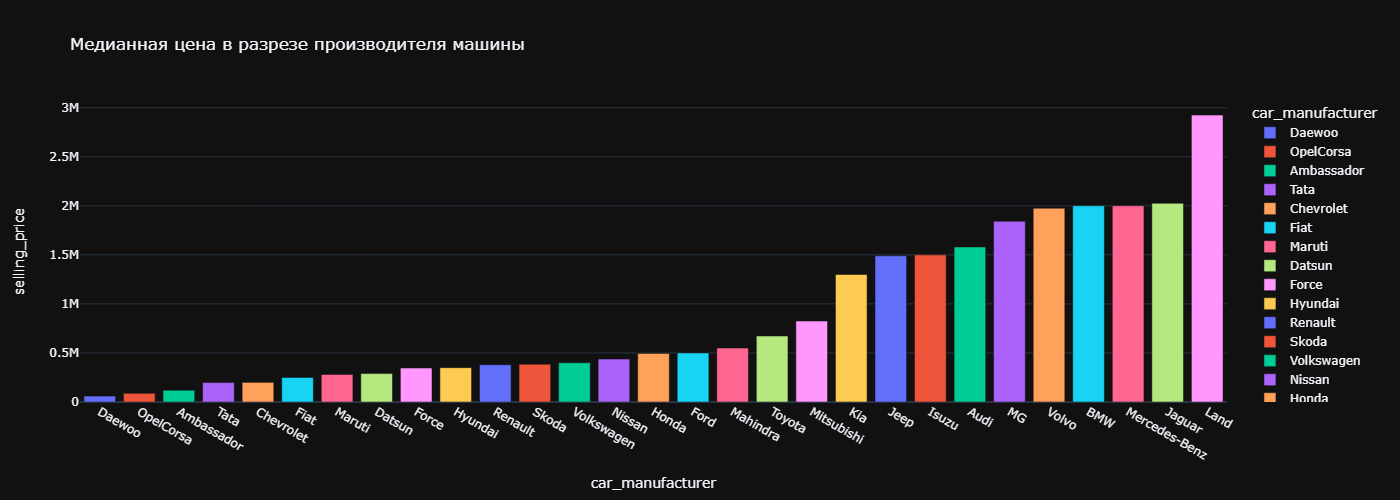

In [16]:
grouped_by_manufact = data.groupby(['car_manufacturer'], as_index=False)['selling_price'].median().sort_values(by='selling_price')
px.bar(
    grouped_by_manufact,
    x='car_manufacturer',
    y='selling_price',
    color='car_manufacturer',
    width=1400,
    height=500,
    title='Медианная цена в разрезе производителя машины',
    template='plotly_dark'
)

## EDA

In [17]:
data = data.reset_index().drop(columns='index')

In [18]:
oh_encoder = preprocessing.OneHotEncoder()
bin_encoder = preprocessing.LabelBinarizer()
ord_encoder = preprocessing.OrdinalEncoder()

oh_cols = ['fuel', 'seller_type', 'owner']
bin_cols = ['car_manufacturer']
ord_cols = ['transmission']
numeric_cols = ['year', 'km_driven', 'selling_price', ]

oh_encoded = pd.DataFrame(oh_encoder.fit_transform(data[oh_cols]).toarray())
bin_encoded = pd.DataFrame(bin_encoder.fit_transform(data[bin_cols]))

oh_col_names = ['oh_'+str(i) for i in oh_encoded.columns]
bin_col_names = ['bin_'+str(i) for i in bin_encoded.columns]

oh_encoded.columns = oh_col_names
bin_encoded.columns = bin_col_names

encoded_data = pd.concat([data, oh_encoded, bin_encoded], axis=1).drop(columns=oh_cols + bin_cols)
encoded_data[ord_cols] = ord_encoder.fit_transform(encoded_data[ord_cols])

In [19]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           4314 non-null   int64  
 1   selling_price  4314 non-null   int64  
 2   km_driven      4314 non-null   int64  
 3   transmission   4314 non-null   float64
 4   oh_0           4314 non-null   float64
 5   oh_1           4314 non-null   float64
 6   oh_2           4314 non-null   float64
 7   oh_3           4314 non-null   float64
 8   oh_4           4314 non-null   float64
 9   oh_5           4314 non-null   float64
 10  oh_6           4314 non-null   float64
 11  oh_7           4314 non-null   float64
 12  oh_8           4314 non-null   float64
 13  oh_9           4314 non-null   float64
 14  oh_10          4314 non-null   float64
 15  oh_11          4314 non-null   float64
 16  oh_12          4314 non-null   float64
 17  bin_0          4314 non-null   int32  
 18  bin_1   

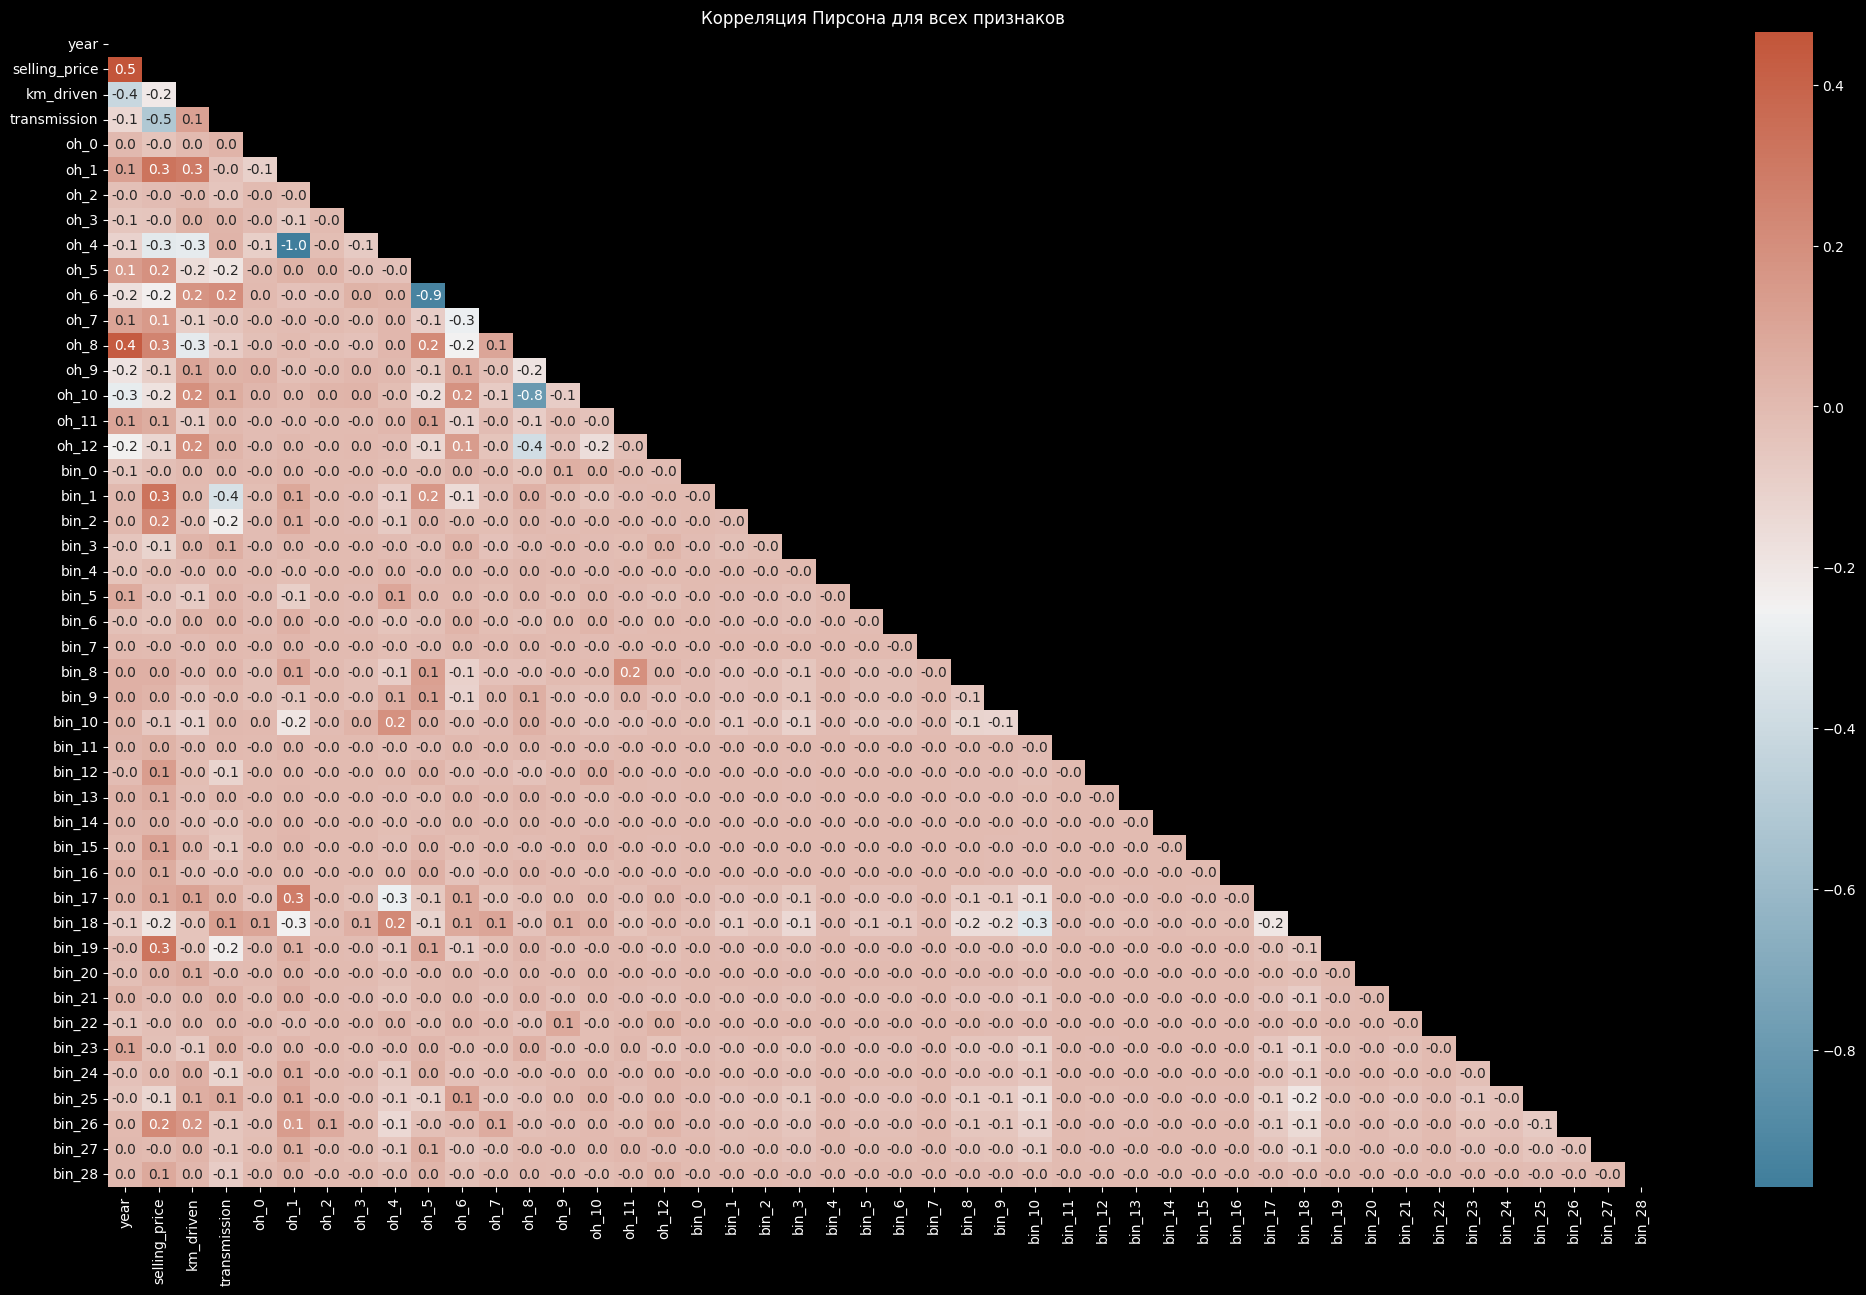

In [20]:
fig, ax = plt.subplots(figsize=(25, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(encoded_data.corr()))
sns.heatmap(
    encoded_data.corr(),
    annot=True, 
    ax=ax,
    cmap=cmap,
    mask=mask,
    fmt='.1f'
).set_title('Корреляция Пирсона для всех признаков');

In [21]:
drop_cols = ['oh_4', 'oh_5']
encoded_data.drop(columns=drop_cols, inplace=True)

## Построение модели

In [22]:
X, y = encoded_data.drop(columns='selling_price'), encoded_data['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3019, 43) (1295, 43) (3019,) (1295,)


### Аналитическое решение линейной регрессии

In [23]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)

y_train_pred = linear_regression.predict(X_train)
y_test_pred = linear_regression.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R2-score: 0.6840194026568105
Test R2-score: 0.7193521765015374
---------------
Train MAE: 161850.19157555085
Test MAE: 164289.56630840633
---------------
Train MAPE: 51.46390945983366
Test MAPE: 56.414717741786255


### Случайный лес

In [24]:
def objective(trial):
    params = dict(
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        max_depth=trial.suggest_int('max_depth', 5, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 5),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 5) 
    )
    
    model = ensemble.RandomForestRegressor(**params)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=N_JOBS).mean()
    
    return score

study_rf = optuna.create_study(study_name='RandomForestRegressor', direction='maximize')
study_rf.optimize(objective, n_trials=20)

[I 2023-04-06 15:01:57,784] A new study created in memory with name: RandomForestRegressor
[I 2023-04-06 15:02:02,953] Trial 0 finished with value: 0.6846270864984236 and parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4}. Best is trial 0 with value: 0.6846270864984236.
[I 2023-04-06 15:02:07,651] Trial 1 finished with value: 0.7896944432617912 and parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 1 with value: 0.7896944432617912.
[I 2023-04-06 15:02:11,790] Trial 2 finished with value: 0.7349559783314601 and parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}. Best is trial 1 with value: 0.7896944432617912.
[I 2023-04-06 15:02:15,904] Trial 3 finished with value: 0.7760460179470611 and parameters: {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 5}. Best is trial 1 with value: 0.7896944432617912.
[I 2023-04-06 15:02:20,320] Trial 4 finished with value: 0.7850714796665628 and parame

In [25]:
best_rf = ensemble.RandomForestRegressor(
    **study_rf.best_params,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

best_rf.fit(X_train, y_train)

y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R2-score: 0.9326981811894868
Test R2-score: 0.8270654109222905
---------------
Train MAE: 77499.6348107694
Test MAE: 111823.73632327408
---------------
Train MAPE: 21.68233290507505
Test MAPE: 30.805906505646412


### Градиентный бустинг

In [26]:
def objective(trial):
    params = dict(
        random_state=RANDOM_STATE,
        max_depth=trial.suggest_int('max_depth', 2, 5),
        learning_rate=trial.suggest_float('learning_rate', 0.1, 1),
        n_estimators=trial.suggest_int('n_estimators', 150, 200)
    )
    
    model = ensemble.GradientBoostingRegressor(**params)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=N_JOBS).mean()
    
    return score

study_gb = optuna.create_study(study_name='GradientBoostingRegressor', direction='maximize')
study_gb.optimize(objective, n_trials=15)
print('Best params:', study_gb.best_params)
print('Best score:', study_gb.best_value)

[I 2023-04-06 15:03:22,110] A new study created in memory with name: GradientBoostingRegressor
[I 2023-04-06 15:03:50,883] Trial 0 finished with value: 0.7477249107306168 and parameters: {'max_depth': 3, 'learning_rate': 0.8694821717082177, 'n_estimators': 198}. Best is trial 0 with value: 0.7477249107306168.
[I 2023-04-06 15:04:28,170] Trial 1 finished with value: 0.7989353423108423 and parameters: {'max_depth': 5, 'learning_rate': 0.375887754878069, 'n_estimators': 175}. Best is trial 1 with value: 0.7989353423108423.
[I 2023-04-06 15:04:54,278] Trial 2 finished with value: 0.8009683019703748 and parameters: {'max_depth': 3, 'learning_rate': 0.37528125082407304, 'n_estimators': 176}. Best is trial 2 with value: 0.8009683019703748.
[I 2023-04-06 15:05:17,666] Trial 3 finished with value: 0.7462587648768659 and parameters: {'max_depth': 3, 'learning_rate': 0.925785124543774, 'n_estimators': 183}. Best is trial 2 with value: 0.8009683019703748.
[I 2023-04-06 15:05:37,810] Trial 4 finish

Best params: {'max_depth': 5, 'learning_rate': 0.15425923313396378, 'n_estimators': 165}
Best score: 0.8098968981051742


In [27]:
best_gb_regressor = ensemble.GradientBoostingRegressor(
    **study_gb.best_params,
    random_state=RANDOM_STATE
)
best_gb_regressor.fit(X_train, y_train)

y_train_pred = best_gb_regressor.predict(X_train)
y_test_pred = best_gb_regressor.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R2-score: 0.9294836589029167
Test R2-score: 0.8452841024655856
---------------
Train MAE: 82226.83856104038
Test MAE: 108818.43766181185
---------------
Train MAPE: 24.42429386432248
Test MAPE: 31.055927792771882


## Визуализируем важность гиперпараметров и признаков у модели с наилучшей метрикой(RandomForestRegressor) 

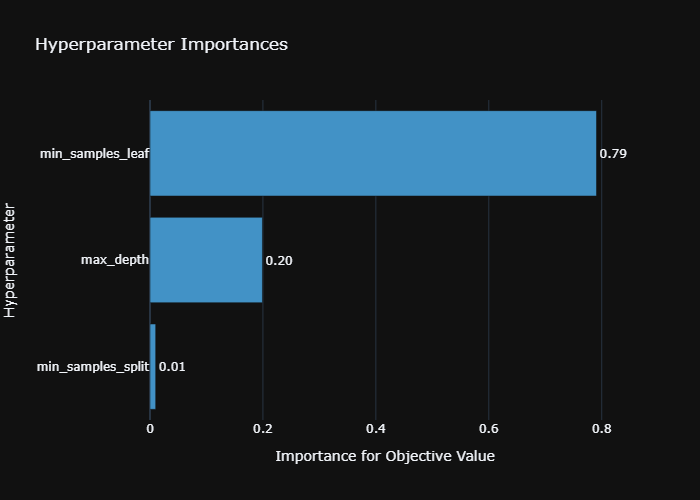

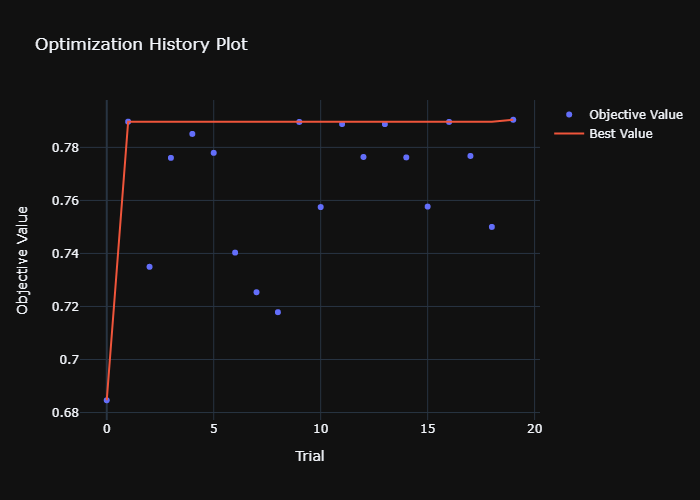

In [28]:
param_imp = optuna.visualization.plot_param_importances(study_rf)
opt_hist = optuna.visualization.plot_optimization_history(study_rf)
param_imp.update_layout(template='plotly_dark')
opt_hist.update_layout(template='plotly_dark')
param_imp.show()
opt_hist.show()

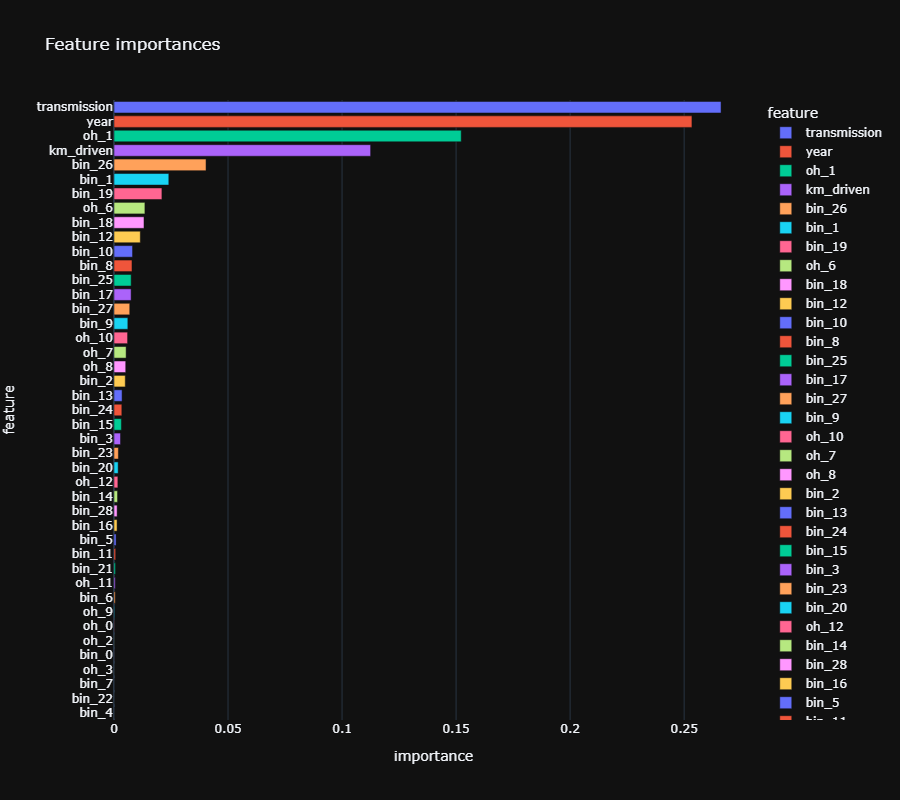

In [29]:
feature_importances = pd.DataFrame(
    data=best_rf.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values(by='importance', ascending=False)
px.bar(
    feature_importances,
    x='importance',
    template='plotly_dark',
    width=900,
    height=800,
    title='Feature importances',
    color=feature_importances.index,
    labels={'index': 'feature'}
)

## Сравнение результатов разных моделей

In [31]:
results_df = pd.DataFrame({
    'Test R2-score': [0.719, 0.827, 0.845],
    'Test MAE, $': [164289.56, 111823.74, 108818.44],
    'Test MAPE, %': [56.41, 30.81, 31.06]
}, index=[
    'LinearRegression',
    'RandomForestRegressor',
    'GradientBoostingRegressor'
])
results_df

,Test R2-score,"Test MAE, $","Test MAPE, %"
LinearRegression,0.719,164289.56,56.41
RandomForestRegressor,0.827,111823.74,30.81
GradientBoostingRegressor,0.845,108818.44,31.06


## Вывод
Наилучший результат показали модели `RandomForestRegressor` и `GradientBoostingRegressor`, их метрики практически не отличаются(в пределах небольшой погрешности). 